# XANES normalization + process correlation for SnO2 reduction 


## Step 1. Import Modules

In [1]:
# File Handling
import os
import pickle

# Plot Handling
import matplotlib.pyplot as plt

# data handling
import numpy as np
import pandas as pd

# Make Plotting interactive
from ipywidgets import interact, fixed

# Wrapper for xraylarch (larch)
os.chdir('..')
pwd = os.getcwd()
os.chdir('./catxas')
import general as fcts
import xas as xfcts
import plot as pfcts
import process
import experiment as exp

%matplotlib inline

## Step 2. Definitions

In [2]:
# Data Location Definitions:

# Folder containing ONLY XAS spectra
data_dir = r'C:\Users\ashoff\OneDrive - SLAC National Accelerator Laboratory\Co-ACCESS Shared Folder\Beamline Data\2024-01 BL 9-3 Hoffman 8014\CXAS\ASH_NiOSiO2'

# Scan naame of one of the XAS spectra - used for inspection of the experiment groups
scan_name = r'20240118_ASH_NiOSiO2_AP_Ni_K_EXAFS_92s.tra_0001'

In [3]:
# Output Definitions: 

# Unique name for the experiment
exp_name = 'ASH_NiOSiO2_TPR'

# Directory where to save the experiment:
pickle_dir = r'C:\Users\ashoff\OneDrive - SLAC National Accelerator Laboratory\Co-ACCESS Shared Folder\Beamline Data\2024-01 BL 9-3 Hoffman 8014\CXAS\catXAS'

# File name to save the sxperiment (must include extension '.pickle')
pickle_name = f'{exp_name}.pickle'

# Folder where results will be saved
output_dir = pickle_dir

In [4]:
# Plotting Defs

Edge_Energy = 8333 # eV

emin = Edge_Energy-50 # eV

emax = Edge_Energy+50 # eV

## Step 3. Define Beamline Data Structure

Common data formats for SSRL beamlines can be found in the "BL specific XAS data structures.ipynb" notebook.

In [5]:
### Define the layout of the xas data file and how spectra are calcualted
xas_data_structure = {
    'time stamp': True,
    'time on line': 5,
    'time format': '# This Scan Create Date:\t%m/%d/%Y %I:%M:%S %p ',
    'padded scan numbers': True,
    'column names': ['Encoder', 'Energy', 'ADC_01', 'ADC_02', 'ADC_03', 'ADC_04', 'ADC_05', 'ADC_06', 'ADC_07', 'ADC_08'],
    'energy column' : 'Energy', # Energy [eV]
    'sample numerator': 'ADC_01', # I0
    'sample denominator': 'ADC_02', # I1
    'sample ln': True,
    'sample invert': False,
    'reference numerator': 'ADC_02', # I1
    'reference denominator': 'ADC_03', # I2
    'reference ln': True,
    'reference invert': False,
    'is QEXAFS': False
}

## Step 4. Add Data to Experiment Object

    The Experiment class is a dictionary-like obect that is used to store XAS data, process data streams, and correlation and fitting results.
    
### Major steps for adding data to the Experiment class:
    a. Create Experiment Class
    b. Load XAS data into the Experiment object
    

### 4a. Create Experiment Class

In [6]:
# Create the Experimental Class
my_exp = exp.Experiment(exp_name)

### 4b. Load XAS data into the Experiment object

In [7]:
# Add raw data into spectra files
my_exp.import_spectra_data(data_dir, xas_data_structure, print_name = False)

In [8]:
print(f'Number of Spectra in folders: {len(my_exp.spectra.keys())}')

Number of Spectra in folders: 80


## Step 5. Clean up Data

    If spectra were collected using CXAS or QXAS there is a chance that the raw data may need cleaning up to remove duplicate data poins or nan/inf values.
    
#### STILL IN DEVELOPMENT

In [9]:
my_exp.organize_RawData(remove_duplicates=True, remove_nan_inf=False, remove_zeros=False) # remove_nan_inf & remove_zeros does not work yet

Duplicate data points removed
Range of data points per raw spectra: 4979-4981
Range of data points per duplicates removed spectra: 4852-4858


## Step 6. Calculate Absorption Spectra

In [10]:
# Calcualte mux for Sample:
sample_spectra = True

# Calcualte mux for Reference:
ref_spectra = True

my_exp.calculate_spectra(sample_spectra = sample_spectra, ref_spectra = ref_spectra)

#### Inspection tools to show results of absorption spectra calculation
    1. Visuaization of an raw absorption spectrum

E0 not defined in 20240118_ASH_NiOSiO2_AP_Ni_K_EXAFS_92s.tra_0001 or function - E0 not plotted
E0 not defined in 20240118_ASH_NiOSiO2_AP_Ni_K_EXAFS_92s.tra_0001_ref or function - E0 not plotted


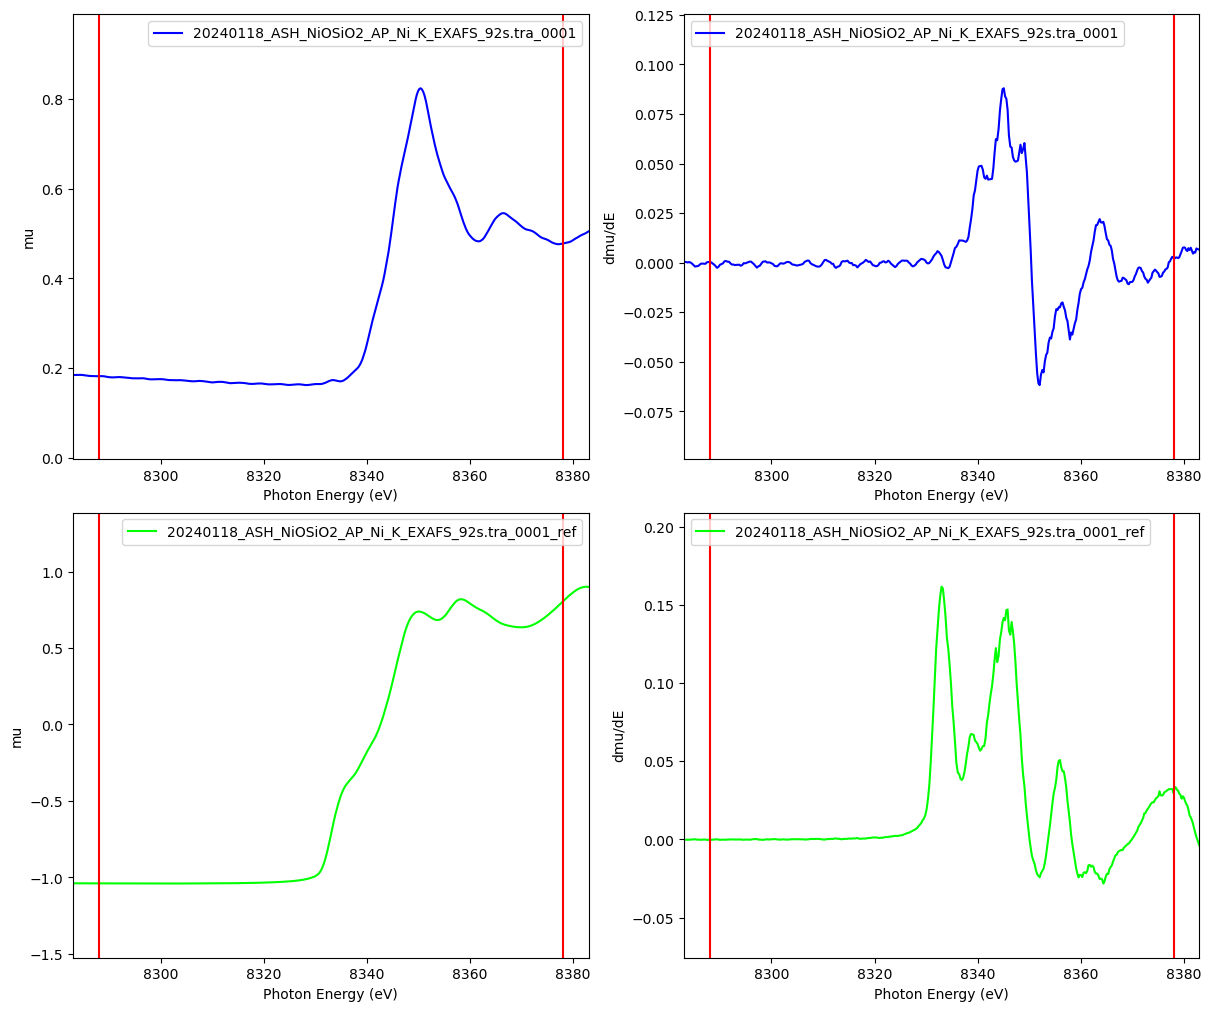

In [11]:
# 1. Visualize absorption spectra of the sample and reference for scan_name.

Samp_group = my_exp.spectra[scan_name]['Absorption Spectra']['mu Sample']
Ref_group = my_exp.spectra[scan_name]['Absorption Spectra']['mu Reference']


pfcts.plot_XANES([Samp_group, Ref_group], emin, emax, spectra = 'mu',  
                 e0 = None, e0_line = True, ref_lines = [emin+5, emax-5], 
                 deriv = True, overlay = False,
                 filtering = True, window_length = 21, polyorder = 4)

## Step 7. Calibrate Energy and Find E0

    Calibration has 2 steps:
        a. Find the edge of the reference spectra and determine the energy shift (delE)
        b. find the E0 value for the sample spectra

    Calibration should be perfromed with the reference channel if possible.
    Calibration can be skipped, however a second step will be needed to set the E0 value for the appropriate spectra [Commented out in example]

    Calibration will find the first inflection point of the data based upon the range set by the suppled values of Ref_E0 value and energy_range.
        Range = Ref_E0 +/- energy_range

    For the reference and the sample, the use_mean parameter will set each spectrum to the mean E0 value found. This is useful as there is no data smoothing on the reference, and will pick an average value for the sample if it is transient.

### Major steps for adding data to the Experiment class:
    a. Calibrate Reference Spectra
    b. Find Sample E0


### 7a. Calibrate Reference Spectra

    There are two options for energy calibration:
        1. Semi-automated - software finds the first derivative maximum in a specified energy range of reference channel
        2. Manual - select edge of reference channel using plot function


    Use either method by converting the code block(s) from "RawNBConvert" to "Code" using the dropdown option at the top fo the screen.

#### MODIFY:
    1. Ref_E0 - set to known energy value for the reference channel
    2. energy_range - how far to look around the theiretical edge to find an inflection point
    3. use_mean - True or False, determiend if each spetra has a unique E0 or if it shared

In [12]:
# Option 2a: Manual edge calibration - Find the Edge

samp_ref = 'mu Reference'
spectra = 'mu'
deriv = True
e0 = None
e0_line = False 
ref_lines = (emin, emax, 0.05)
overlay = True
use_legend = False
cmap_name = 'brg'
filtering = False
window_length = 31
polyorder = 4

# Reset delE
delE_params = {'delE': 0,
              'e0': None}

# Sample
my_exp.load_params('mu Sample', delE_params)

# Reference
my_exp.load_params('mu Reference', delE_params)

interact(my_exp.plot_XANES_spectra,
         emin = fixed(emin),
         emax = fixed(emax),
         samp_ref = fixed(samp_ref),
         spectra = fixed(spectra),
         deriv = fixed(deriv),
         e0 = fixed(e0),
         e0_line = fixed(e0_line),
         ref_lines = ref_lines,
         overlay = fixed(overlay),
         use_legend = fixed(use_legend),
         cmap_name = fixed(cmap_name),
         filtering = fixed(filtering),
         window_length = fixed(window_length),
         polyorder = fixed(polyorder))

interactive(children=(FloatSlider(value=8333.0, description='ref_lines', max=8383.0, min=8283.0, step=0.05), O…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [13]:
# Option 2b: Manual edge calibration - Apply del E and E0

# Modify as needed:

found_edge = 8333

# DO NOT NEED TO MODIFY BELOW
delE = Edge_Energy-found_edge

ref_edge_params = {'delE': delE,
                   'e0': Edge_Energy}

samp_edge_params = {'delE': delE}

# Sample
my_exp.load_params('mu Sample', samp_edge_params)

# Reference
my_exp.load_params('mu Reference', ref_edge_params)

print(f'delE parameter: {delE:0.2f}')

delE parameter: 0.00


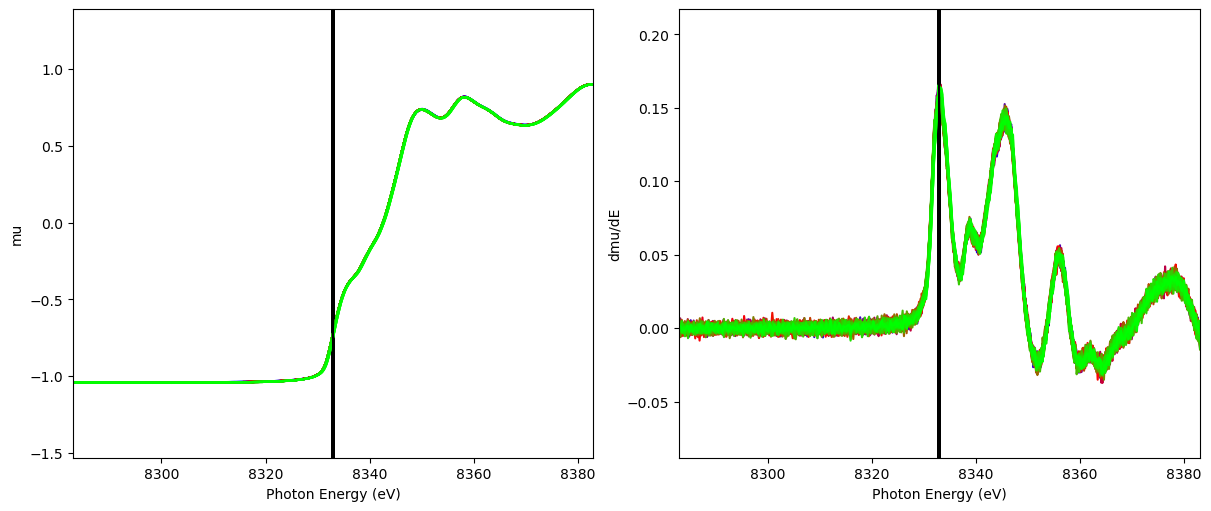

In [14]:
# Option 2b: Manual edge calibration - Check Energy Calibration with Reference Channel

my_exp.plot_XANES_spectra(emin, emax, samp_ref = 'mu Reference', spectra = 'mu', deriv = True, 
                          e0 = None, e0_line = True, 
                          ref_lines = None, overlay = True, use_legend = False, cmap_name = 'brg', 
                          filtering = False, window_length = 5, polyorder = 2)

### 7b. Find Sample E0
    
    There are two options for sample edge (E0) finding:
        1. Semi-automated - software finds the first derivative maximum in a specified energy range of the sample
        2. Manual - select edge of sample channel using plot function


    Use either method by converting the code block(s) from "RawNBConvert" to "Code" using the dropdown option at the top fo the screen.

#### MODIFY:
    1. Samp_e0 - approximate edge position of the sample
    2. energy_range - how far to look around the theiretical edge to find an inflection point
    3. use_mean - True or False, determiend if each spetra has a unique E0 or if it shared

In [15]:
# Option 2a: Manual edge finding

# Modify as needed:


# DO NOT NEED TO MODIFY BELOw
samp_ref = 'mu Sample'
spectra = 'mu'
deriv = True
e0 = None
e0_line = False 
ref_lines = (emin, emax, 0.05)
overlay = True
use_legend = False
cmap_name = 'brg'
filtering = True
window_length = 21
polyorder = 2

interact(my_exp.plot_XANES_spectra,
         emin = fixed(emin),
         emax = fixed(emax),
         samp_ref = fixed(samp_ref),
         spectra = fixed(spectra),
         deriv = fixed(deriv),
         e0 = fixed(e0),
         e0_line = fixed(e0_line),
         ref_lines = ref_lines,
         overlay = fixed(overlay),
         use_legend = fixed(use_legend),
         cmap_name = fixed(cmap_name),
         filtering = fixed(filtering),
         window_length = fixed(window_length),
         polyorder = fixed(polyorder))

interactive(children=(FloatSlider(value=8333.0, description='ref_lines', max=8383.0, min=8283.0, step=0.05), O…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [16]:
# Option 2b: Manual edge finding - Apply  E0

# Modify as needed:

found_edge = 8339

# DO NOT NEED TO MODIFY BELOW

samp_edge_params = {'e0': found_edge}

# Sample
my_exp.load_params('mu Sample', samp_edge_params)

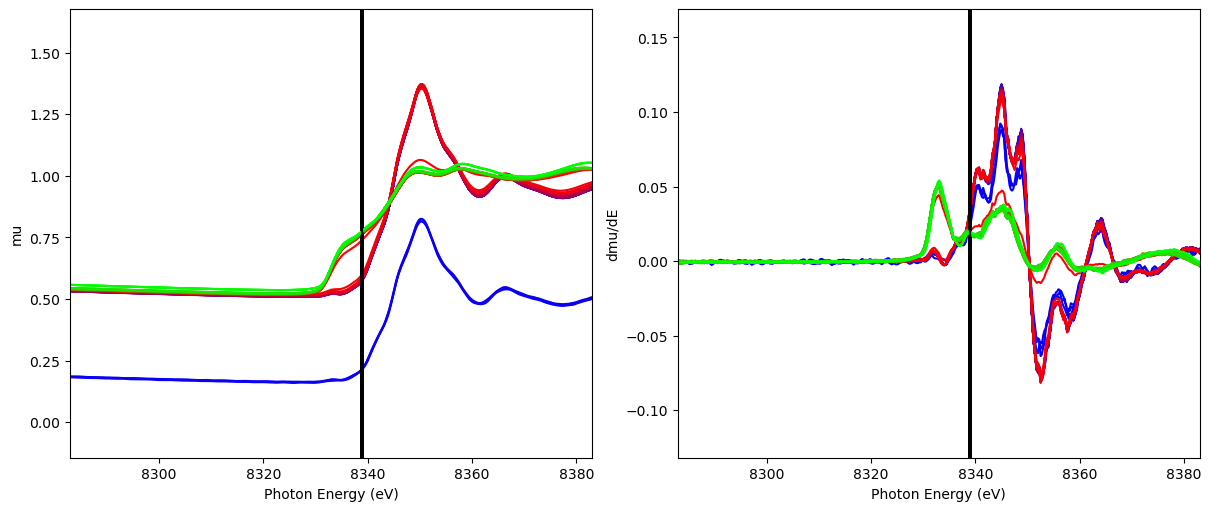

In [17]:
# Option 2b: Manual edge finding - Check Edge position of Sample Channel

my_exp.plot_XANES_spectra(emin, emax, samp_ref = 'mu Sample', spectra = 'mu', deriv = True, 
                          e0 = None, e0_line = True, 
                          ref_lines = None, overlay = True, use_legend = False, cmap_name = 'brg', 
                          filtering = True, window_length = 21, polyorder = 4)

## Step 8. Remove BL data from experimental class

In [18]:
for key in my_exp.__dict__['spectra'].keys():
    my_exp.__dict__['spectra'][key].pop('BL Data')

## Step 9. Normalize Spectra

    Normalization using the same parameters as Athena.

### Major steps for normalization will:
    a. Scan the energy ranges of the data and suggest normalization parameters (spectra files need an E0 value)
    b. Set the normalization parameters
    c. Normalize the spectra

### 9a. Define normalization paramaters

In [19]:
# Inspect each spectrum's energy range and suggest normalization paramters

df1 = my_exp.check_Energy_Range(has_e0 = True, spectra_name = 'mu Sample', print_summary = True)

df2 = my_exp.check_Energy_Range(has_e0 = True, spectra_name = 'mu Reference', print_summary = True)

Energy Range and Energy-Step Summary for mu Sample
	Variation in starting energy points between spectra [eV]: 8133.62-8134.00
	Variation in ending energy points between spectra [eV]: 9307.91-9308.31
	Variation in step size of energy points between spectra [eV]: 0.24-0.24

Normalization Parameters for mu Sample
	Edge Energy Range [E0]: 8339.00-8339.00 eV
	Pre-edge start/stop Suggestion [pre1/pre2]: -150/-50
	Post-edge start/stop Suggestion [norm1/norm2]: 75/700
	Normalizaion order Suggestion [nnorm]: 2
	Flatten Spectra Suggestion [make_norm]: True

Energy Range and Energy-Step Summary for mu Reference
	Variation in starting energy points between spectra [eV]: 8133.62-8134.00
	Variation in ending energy points between spectra [eV]: 9307.91-9308.31
	Variation in step size of energy points between spectra [eV]: 0.24-0.24

Normalization Parameters for mu Reference
	Edge Energy Range [E0]: 8333.00-8333.00 eV
	Pre-edge start/stop Suggestion [pre1/pre2]: -150/-50
	Post-edge start/stop Suggesti

In [20]:
# Update values in the dictionary based upon summary results above

#Refernece Normalization paramters, referenced to E0
Ref_norm_params = {'pre1': -150,
                    'pre2': -50,
                    'norm1': 75,
                    'norm2': 700,
                    'nnorm': 2,
                    'make_flat': True
                   }

#Sample Normalization paramters, referenced to E0
Samp_norm_params = {'pre1': -150,
                    'pre2': -50,
                    'norm1': 75,
                    'norm2': 700,
                    'nnorm': 2,
                    'make_flat': True
                   }

### 9b. Import parameters into each spectrum's larch group

Note: This step can be repeated as needed to upload additional parameters

In [21]:
# Load normalization parameters into larch groups

# Sample
my_exp.load_params('mu Sample', Samp_norm_params)

# Reference
my_exp.load_params('mu Reference', Ref_norm_params)

### 9c. Normalize the spectra

Note: Normalization steps can be run with updated parameters as needed.

In [22]:
# Normalize Specta
my_exp.normalize_spectra('mu Reference')
my_exp.normalize_spectra('mu Sample')

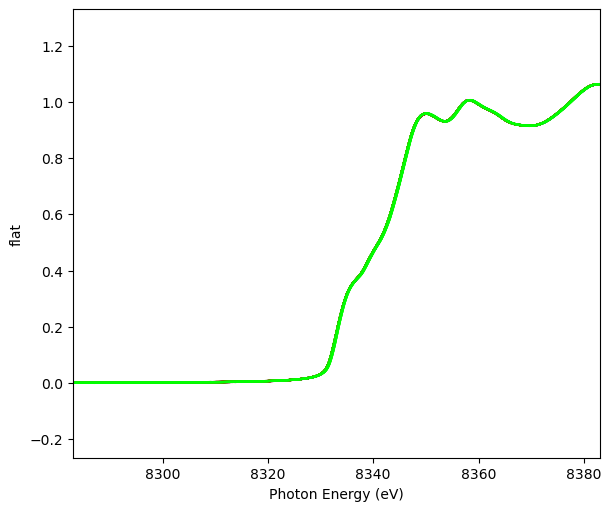

In [23]:
# Visualization of Normalized Spectra - Reference
    
R_groups = []

for key in my_exp.spectra.keys():
    R_groups.append(my_exp.spectra[key]['Absorption Spectra']['mu Reference'])

pfcts.plot_XANES(R_groups, emin, emax, spectra = 'flat', 
                 deriv = False, e0 = None, e0_line = False, 
                 overlay = True, use_legend = False)

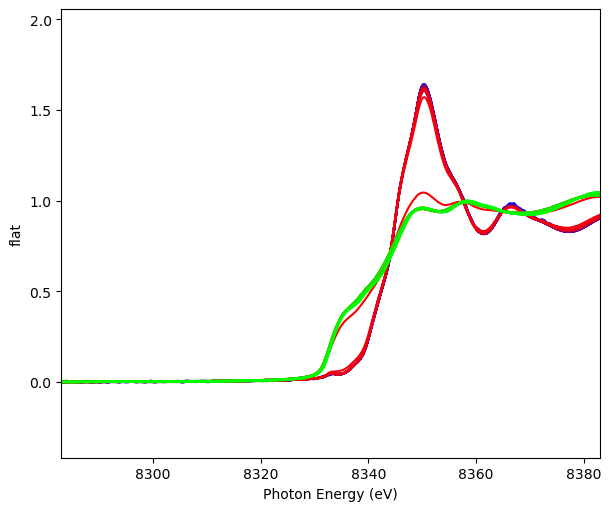

In [24]:
#. Visualization of Normalized Spectra - Sample


S_groups = []


for key in my_exp.spectra.keys():
    S_groups.append(my_exp.spectra[key]['Absorption Spectra']['mu Sample'])
    
pfcts.plot_XANES(S_groups, emin, emax, spectra = 'flat', 
                 deriv = False, e0 = None, e0_line = False, 
                 overlay = True, use_legend = False)

# EXAFS Extraction

In [25]:
# Sample background subtraction paramters

Samp_bkg_params = {'rbkg': 1,
                  'nknots': None, 
                  'kmin': 0, # Default value = 0, lower spline range
                  'kmax': 15.8, # Default value = None, upper spline range
                  'kweight': 2, # Default value = 1, Rarely Change
                  'dk': 0.1,
                  'win': 'hanning', 
                  'nfft': 2048, # Never Change 
                  'kstep': 0.05, # Never Change
                  'k_std': None, # Never Change
                  'chi_std': None, # Never Change
                  'nclamp': 2,
                  'clamp_lo': 0, 
                  'clamp_hi': 100, 
                  'err_sigma': 1
                   }

# Refernece background subtraction paramters

Ref_bkg_params = {'rbkg': 1,
                  'nknots': None, 
                  'kmin': 0, # Default value = 0, lower spline range
                  'kmax': 13, # Default value = None, upper spline range
                  'kweight': 1, # Default value = 1, Rarely Change
                  'dk': 0.1,
                  'win': 'hanning', 
                  'nfft': 2048, # Never Change 
                  'kstep': 0.05, # Never Change
                  'k_std': None, # Never Change
                  'chi_std': None, # Never Change
                  'nclamp': 2,
                  'clamp_lo': 0, 
                  'clamp_hi': 100, 
                  'err_sigma': 1
                   }

# Load background subtraction parameters into larch groups

# Sample
my_exp.load_params('mu Sample', Samp_bkg_params)

# Reference
my_exp.load_params('mu Reference', Ref_bkg_params)

# Extract EXAFS for each spectum

# Sample
my_exp.extract_EXAFS_spectra('mu Sample')

# Reference
my_exp.extract_EXAFS_spectra('mu Reference')

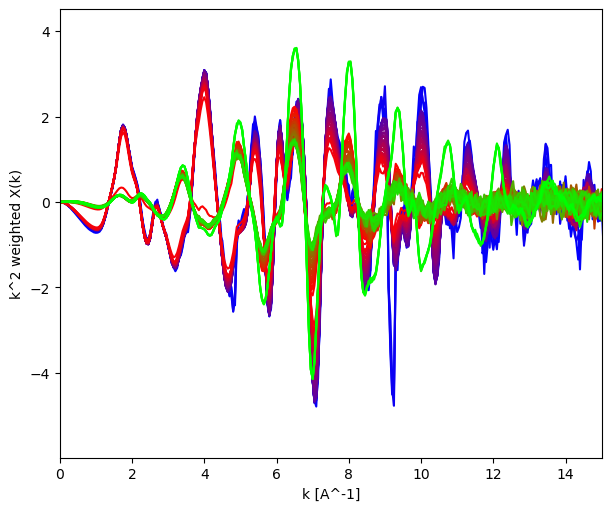

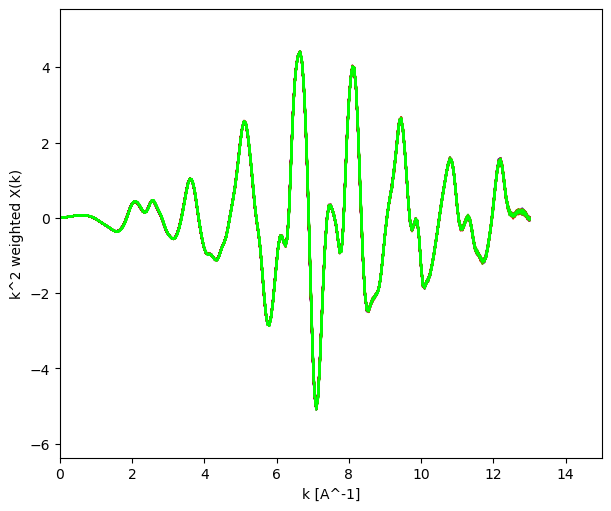

In [26]:
# 2. Visualization of the Extracted EXAFS

# MODIFY: k_weight, kmin, kmax for Sample and Reference

Samp_k_wt = 2
Samp_kmin = 0
Samp_kmax = 15

Ref_k_wt = 2
Ref_kmin = 0
Ref_kmax = 15

# DO NOT MODIFY BELOW

# Sample

S_groups = []

for key in my_exp.spectra.keys():
    S_groups.append(my_exp.spectra[key]['Absorption Spectra']['mu Sample'])
    
pfcts.plot_chi(S_groups, kweight = Samp_k_wt, kmin = Samp_kmin, kmax = Samp_kmax,
               overlay = True, use_legend = False)

# Reference
    
R_groups = []

for key in my_exp.spectra.keys():
    R_groups.append(my_exp.spectra[key]['Absorption Spectra']['mu Reference'])

pfcts.plot_chi(R_groups, kweight = Ref_k_wt, kmin = Ref_kmin, kmax = Ref_kmax, 
               overlay = True, use_legend = False)

In [27]:
# Refernece FT paramters
Ref_FT_params = {'rmax_out': 10,
                  'kmin': 3,
                  'kmax': 11,
                  'kweight': 2,
                  'dk': 5,
                  'dk2': 5,
                  'window': 'haning',
                  'nfft': 2048, # Never Change
                  'kstep': 0.05 # Never Change
                 }

# Sample FT paramters
Samp_FT_params = {'rmax_out': 10,
                  'kmin': 3,
                  'kmax': 11,
                  'kweight': 2,
                  'dk': 5,
                  'dk2': 5,
                  'window': 'haning',
                  'nfft': 2048, # Never Change
                  'kstep': 0.05 # Never Change
                 }

# Load FT parameters into larch groups

# Sample
my_exp.load_params('mu Sample', Samp_FT_params)

# Reference
my_exp.load_params('mu Reference', Ref_FT_params)

# Perform FT of EXAFS for each spectum

# Sample
my_exp.FT_EXAFS_spectra('mu Sample')

# Reference
my_exp.FT_EXAFS_spectra('mu Reference')

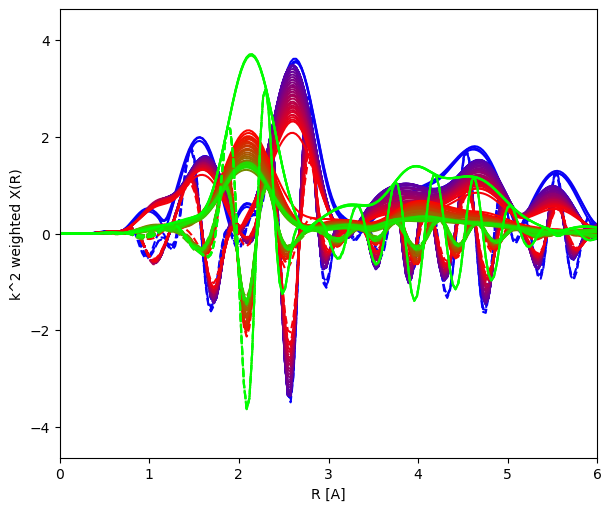

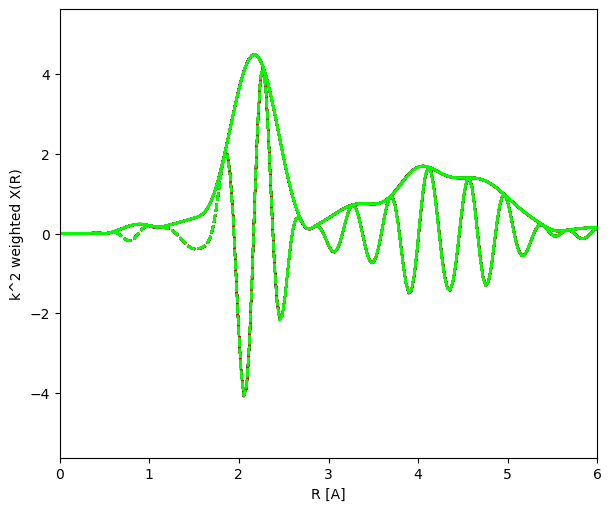

In [28]:
# 2. Visualization of the Fourier-Transformed EXAFS

# MODIFY: Rmin, Rmax, magnitide, imaginary, real for Sample and Reference

Samp_Rmin = 0
Samp_Rmax = 6
Samp_magnitude = True # Show Magnutide of FT
Samp_imaginary = True # Show Imaginary Component of FT
Samp_real = False # Show Real Component of FT

Ref_Rmin = 0
Ref_Rmax = 6
Ref_magnitude = True # Show Magnutide of FT
Ref_imaginary = True # Show Imaginary Component of FT
Ref_real = False # Show Real Component of FT



# DO NOT MODIFY BELOW

# Sample

S_groups = []

for key in my_exp.spectra.keys():
    S_groups.append(my_exp.spectra[key]['Absorption Spectra']['mu Sample'])
    
pfcts.plot_FT(S_groups, Rmin = Samp_Rmin, Rmax = Samp_Rmax, 
              magnitude = Samp_magnitude, imaginary = Samp_imaginary, real = Samp_real, 
              overlay = True, use_legend = False)

# Reference
    
R_groups = []

for key in my_exp.spectra.keys():
    R_groups.append(my_exp.spectra[key]['Absorption Spectra']['mu Reference'])

pfcts.plot_FT(R_groups, Rmin = Ref_Rmin, Rmax = Ref_Rmax, 
              magnitude = Ref_magnitude, imaginary = Ref_imaginary, real = Ref_real, 
              overlay = True, use_legend = False)

## Step 14. Save Experiment with 'pickle'

    Pickle - A method to save the experimental class and reopen it elsewhere.

In [29]:
pickle_path = os.path.join(pickle_dir,pickle_name)

pickle_out = open(pickle_path,"wb")
pickle.dump(my_exp, pickle_out)
pickle_out.close()